# Discharge Capacity Model for Lithium-Ion Battery Cells

## Problem statement

This project aims to create a model of discharge capacity change with respect to the number of discharge cycles of a lion battery cell.

## Introduction
When utilizing a lithium-ion battery, it is crucial to monitor the degradation of the battery over time. This can be done by tracking the value of different parameters such as discharge capacity or State of Health (SoH). Due to that the estimations of those parameters are crucial aspect in the field of the battery management systems. 

The discharge capacity refers to the maximum amount of charge that can be extracted from a battery till reaching a certain voltage threshold, while SoH estimation helps assess the overall health and performance of the battery over its lifespan. The SoH itself is defined as the ratio of the current discharge capacity of the cell to the rated capacity. The formula for this parameter is:
$$SoH = \frac{C_{discharge}}{C_{rated}}$$

The rated capacity $C_{rated}$ for a lithium-ion cell is constant and the discharge capacity $C_{discharge}$ decreases over time, therefore by estimating the discharge capacity it is possible to estimate the SoH of the battery as well.

This project focuses on developing a model for estimating the discharge capacity and SoH of a lithium-ion battery using Stan, a powerful probabilistic programming language. The primary objective is to create a model capable of predicting those parameters with high accuracy and low uncertainty with each discharging cycle.

## Purpose of Creating the Model
The model for discharge capacity and SoH estimation holds several key purposes, including:
1. **Battery Performance Optimization** - accurate estimation of discharge capacity for the evaluation of the battery's condition and performance degradation. By understanding the maximum charge that can be extracted from the battery, better management and control of the battery system can be achieved, leading to improved efficiency and longevity.
2. **Battery Health Monitoring** - accurate estimation of SoH over time allows for the evaluation of the battery's condition and performance degradation. By understanding the current health of the battery, it is possible to predict the remaining lifespan of the battery and to replace it before it fails. This is especially important in applications where the battery is used in critical systems, such as in electric vehicles or in medical devices.
3. **Electric Vehicle Range Estimation** - accurate estimation of SoH and discharge capacity play a key role in estimating the remaining range of an electric vehicle, as these are parameters that directly affect the capabilities of the battery. This information is vital for drivers to plan their journeys and manage their battery usage efficiently.

In addition to these general purposes, the specific focus of this project is to apply the developed SoH and discharge capacity prediction model to the solar panels powered Celka boat. The model will be utilized to predict the current state-of-health of the li-on based battery pack and to estimate number of cycles remaining for the battery on the Celka boat. This specific application aims to enhance the utilization of the battery pack and to improve the overall performance of the boat, as well as to predict the time when the battery pack will need to be replaced.

## NASA Battery Dataset
[cleaned_dataset](./cleaned_dataset) directory contains the NASA Battery Dataset, which provides valuable information about battery performance, degradation, and failure.  We decided to use an already pre-processed version to accelerate data exploration which was introduced in 29 October 2022 as Version 2 of the dataset. This dataset is suitable for various data analysis and modeling tasks related to batteries. It includes repeated charge and discharge cycles to simulate battery aging, along with impedance measurements that offer insights into internal battery parameters as aging progresses.

This dataset is sourced from [Kaggle](https://www.kaggle.com/datasets/patrickfleith/nasa-battery-dataset), provided by [Patrick Fleith](https://www.kaggle.com/patrickfleith). 

**NOTE:** For more informations about the dataset please refer to the created by us [README.md](./cleaned_dataset/README.md) file.

## DAG

![soh_data.drawio.png](soh_data.drawio.png)

## "Confoundings" in the model

![confoundings.png](confoundings.png)

In our case the starting discharge capacity is confounding the direct relationship between measured discharge capacity and cycles to discharge.

Other variables, such as ambient temperature during the experiment, could be considered, but they seem to be consistent enough across all experiments that we won't.

## Data Preprocessing & Extraction
For project purpouses we decided to use only data for the specific batteries with ID due to the common expriements background:
- B0005
- B0006
- B0007

Description of the expirements for those batteries can be found in [README_05_06_07_18](./cleaned_dataset/extra_infos/README_05_06_07_18.txt) file.

### Part of the README_05_06_07_18.txt file
```
Data Description:
A set of four Li-ion batteries (# 5, 6, 7 and 18) were run through 3 different operational profiles 
(charge, discharge and impedance) at room temperature. Charging was carried out in a constant current (CC) 
mode at 1.5A until the battery voltage reached 4.2V and then continued in a constant voltage (CV) mode 
until the charge current dropped to 20mA. Discharge was carried out at a constant current (CC) level of 2A 
until the battery voltage fell to 2.7V, 2.5V, 2.2V and 2.5V for batteries 5 6 7 and 18 respectively. 
Impedance measurement was carried out through an electrochemical impedance spectroscopy (EIS) frequency sweep 
from 0.1Hz to 5kHz. Repeated charge and discharge cycles result in accelerated aging of the batteries while 
impedance measurements provide insight into the internal battery parameters that change as aging progresses. 
The experiments were stopped when the batteries reached end-of-life (EOL) criteria, which was a 30% fade 
in rated capacity (from 2Ahr to 1.4Ahr). This dataset can be used for the prediction of both remaining charge 
(for a given discharge cycle) and remaining useful life (RUL).
```

Those data were exported from the original dataset that can be found in [cleaned_dataset](./cleaned_dataset) directory to the `picked_data` dictionary by the below python code block.

In [273]:
import pandas as pd
import csv
from tqdm import tqdm

# Picked data
picked_data = {
    'battery_id': ['B0005', 'B0006', 'B0007'],
    'cycle_type': ['discharge']
}

metadata_path = 'cleaned_dataset/metadata.csv'
data = {}

# Read metadata.csv and creating data dictionary
with open(metadata_path, 'r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        battery_id = row['battery_id']
        if battery_id in picked_data['battery_id']:
            data[battery_id] = {
                'charge': {},
                'discharge': {},
                'impedance': {}
            }

data_path = 'cleaned_dataset/data/'

cycle_ids = {
    'charge': 0,
    'discharge': 0,
    'impedance': 0
}

# Read and store metadata information for analyzed batteries
metadata = pd.read_csv('cleaned_dataset/metadata.csv')

# Create a progress bar
pbar = tqdm(total=len(metadata))

# Iterate over each row in the metadata dataframe
for index, row in metadata.iterrows():
    if index == 0:
        metadata_headers = row.keys()

    if row['battery_id'] != battery_id:
        cycle_ids = {
            'charge': 0,
            'discharge': 0,
            'impedance': 0
        }
    cycle_type = row['type']
    cycle_id = cycle_ids[cycle_type]
    battery_id = row['battery_id']

    if cycle_type in picked_data['cycle_type'] and battery_id in picked_data['battery_id']:
        values_metadata = {}
        # To values append non-empty values of metadata headers
        for header in metadata_headers:
            if row[header] != '':
                values_metadata[header] = row[header]

        filename = row['filename']

        with open(data_path+filename, 'r') as csvfile:
            csvreader = csv.DictReader(csvfile)
            headers = csvreader.fieldnames
            values = {header: [] for header in headers}
            for row in csvreader:
                for header in headers:
                    values[header].append(row[header])
            
            # Concatenate metadata and data values
            values = {**values_metadata, **values}
            data[battery_id][cycle_type][cycle_id] = values
            csvfile.close()
        cycle_ids[cycle_type] += 1

    # Update the progress bar
    pbar.update(1)

# Close the progress bar
pbar.close()


 61%|██████    | 4618/7565 [00:00<00:00, 45841.12it/s]

100%|██████████| 7565/7565 [00:00<00:00, 15632.59it/s]


### Feature extraction
The extraction of features is done in a common way for all datasets for all batteries.


`start_voltage` - For each discharge cycle, we take the initial (start) voltage value. Expressed in volts [V].

`stop_voltage` - For each discharge cycle, we take the final (end) voltage value. This value is taken at the point where the load current changes from -2A to ~0A. Expressed in volts [V].

`current_ptp` - The total time the constant load was applied. Expressed in seconds [s].

To simplify the code here, we've put the feature extraction code in a separate Python file: `feature_extraction/features.py`

In [274]:
from feature_extraction import features
import numpy as np

# function array string to array float
def array_str_to_float(array_str):
    array_float = []
    for i in range(len(array_str)):
        array_float.append(float(array_str[i]))
    return array_float

# add features to data dictionary
for battery_id in data.keys():
    for cycle_type in data[battery_id].keys():
        for cycle_id in data[battery_id][cycle_type].keys():
            if cycle_type == 'discharge':
                data[battery_id][cycle_type][cycle_id]['start_voltage'] = features.get_start_voltage(
                    pd.Index(array_str_to_float(data[battery_id][cycle_type][cycle_id]['Voltage_measured'])))
                data[battery_id][cycle_type][cycle_id]['stop_voltage'] = features.get_stop_voltage(
                    pd.Index(array_str_to_float(data[battery_id][cycle_type][cycle_id]['Voltage_measured'])))
                data[battery_id][cycle_type][cycle_id]['current_ptp'] = features.get_current_ptp(
                    pd.Index(array_str_to_float(data[battery_id][cycle_type][cycle_id]['Current_measured'])),
                    pd.Index(array_str_to_float(data[battery_id][cycle_type][cycle_id]['Time'])))
                
# print example data
print(data['B0005']['discharge'][0])

{'type': 'discharge', 'start_time': '[2.0080e+03 4.0000e+00 2.0000e+00 1.5000e+01 2.5000e+01 4.1593e+01]', 'ambient_temperature': 24, 'battery_id': 'B0005', 'test_id': 1, 'uid': 5122, 'filename': '05122.csv', 'Capacity': '1.8564874208181574', 'Re': nan, 'Rct': nan, 'Voltage_measured': ['4.191491807505295', '4.190749067776103', '3.9748709122299895', '3.9517167075108937', '3.934352489432596', '3.920058441667911', '3.9079035099130923', '3.8970357216910942', '3.8874765805404445', '3.878958592475142', '3.871015984807792', '3.863479677493402', '3.856660507031456', '3.850013579168339', '3.8438419054138055', '3.837687975719061', '3.831938252983524', '3.826414443009924', '3.8210957343825593', '3.815896664668625', '3.8106968219063564', '3.8058373809696873', '3.801121633463299', '3.7962931305502456', '3.7914489063900754', '3.78662468670613', '3.782062923033413', '3.7771754018686496', '3.7724062939793614', '3.7679374591949557', '3.7632293036403497', '3.7585114920291285', '3.754213210075249', '3.74

Since we'll be trying to fit the discharge capacity over multiple cycles for different batteries, the data is organized into a dictionary as visible above.

Not all features will be used in proposed models.

### Visualization of analyzed data

Below we visualize how these parameters change over the number of discharge cycles:
- Discharge time.
- Capacity.
- SoH.


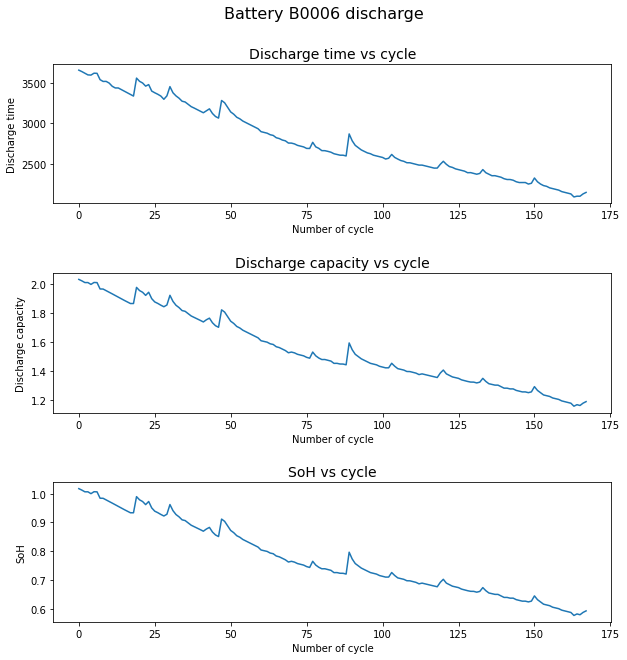

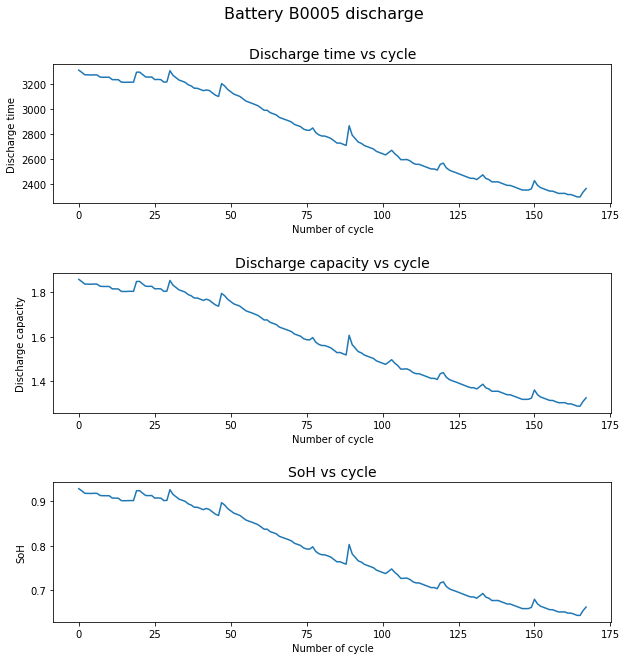

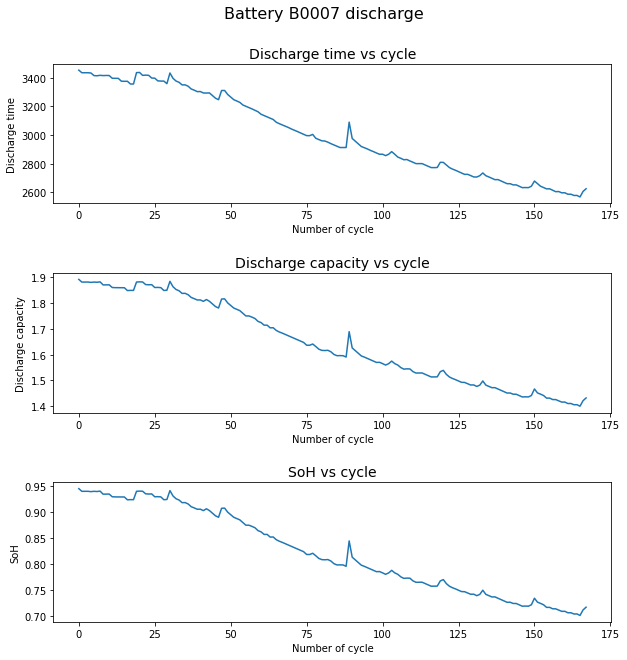

In [275]:
import matplotlib.pyplot as plt

rated_capacity = 2.0 # taken from metadata
# plot discharge time vs cycle
for battery_id in data.keys():
    for cycle_type in data[battery_id].keys():
        if cycle_type == 'discharge':
            cycles = list(data[battery_id][cycle_type].keys())
            discharge_capacities = [float(data[battery_id][cycle_type][cycle_id]['Capacity']) for cycle_id in cycles]
            soh_values = [discharge_capacities[i] / rated_capacity for i in range(len(discharge_capacities))]
            # concatenate each current_ptp for specific battery into one array
            discharge_times = [data[battery_id][cycle_type][cycle_id]['current_ptp'] for cycle_id in cycles]

            # create a figure with 3 subplot
            fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))
            fig.suptitle('Battery ' + battery_id + ' discharge', fontsize=16)
            fig.subplots_adjust(top=0.9, hspace=0.5)
            # plot cycles vs discharge time
            ax1.plot(cycles, discharge_times)
            ax1.set_xlabel('Number of cycle')
            ax1.set_ylabel('Discharge time')
            ax1.set_title('Discharge time vs cycle')
            ax1.title.set_size(14)

            # plot cycles vs discharge capacity
            ax2.plot(cycles, discharge_capacities)
            ax2.set_xlabel('Number of cycle')
            ax2.set_ylabel('Discharge capacity')
            ax2.set_title('Discharge capacity vs cycle')
            ax2.title.set_size(14)

            # plot cycles vs soh
            ax3.plot(cycles, soh_values)
            ax3.set_xlabel('Number of cycle')
            ax3.set_ylabel('SoH')
            ax3.set_title('SoH vs cycle', )
            ax3.title.set_size(14)
            plt.show()
            fig.savefig('plots/battery_' + battery_id + '_discharge.png')

By just looking at these plots, we can see how closely SoH, Discharge time and discharge capacity relate to each other (`!!when the load is constant, in this case -2A!!`).

# Models

## Model 1 - Bayesian linear regression model with centralized parameterization

**Model description:**

This model draws inspiration from the research presented in ["Recognizing VSC DC Cable Fault Types Using Bayesian Functional Data Depth"](https://www.mdpi.com/1996-1073/14/18/5893) paper by authors: Jerzy Baranowski, Katarzyna Grobler-Dębska, and Edyta Kucharska. 

Although the model presented in the paper uses QR decomposition to fit the Bayesian linear regression model with a spline prior on the coefficients, in our project a centered parameterization instead of QR decomposition is used. This approach was chosen because centered parameterization has the advantage of being simpler to implement and can often be more efficient in computation compared to the QR decomposition approach.

The model is a Bayesian linear regression model with a spline prior on the coefficients. Model performs regression of the dataset of $N$ observations with $K$ predictors. The uncentered coefficients $\boldsymbol{\beta}_{\text{raw}}$ are transformed to centered coefficients $\boldsymbol{\beta}$ by applying the spline prior mean $\mu_0$ and standard deviation $\sigma_0$. The model predicts outcomes $\mathbf{y}$ using the centered coefficients and generates predicted values $\mathbf{y}_{\text{pred}}$ by sampling from the normal distribution with mean $\mathbf{\mu}$ and standard deviation $\sigma$.

1. Data:
    - $N$ - Number of data points (observations).
    - $K$ - Number of predictors (features).
    - $L$ - Number of simulated samples (used for generating predicted values).
    - $\mathbf{x}$ - Predictor matrix (dimensions $N \times K$).
    - $\mathbf{y}$ - Output vector (length $N$).

2. Parameters:
    - $\boldsymbol{\beta}_{\text{raw}}$ - Uncentered coefficeints ($K$-dimensional vector).
    - $\sigma$ - Error scale (standard deviation of the error term).
    - $\mu_0$ - Hyperparameter for the spline prior mean (intercept term).
    - $\sigma_0$ - Hyperparameter for the spline prior standard deviation.

3. Transformed parameters:
    - $\boldsymbol{\beta}$ - Centered coefficients ($K$-dimensional vector).

4. Model:
   - Priors:
     - $\boldsymbol{\beta}_{\text{raw}} \sim \text{Normal}(0, 1)$ - uncentered coefficients follow a standard normal distribution.
     - $\sigma \sim \text{Exponential}(0.1)$ - error scale follows an exponential distribution with rate parameter 0.1.
   - Likelihood:
     - $\mathbf{y} \sim \text{Normal}(\mathbf{x} \cdot \boldsymbol{\beta}, \sigma)$ - output vector follows a normal distribution with mean $\mathbf{x} \cdot \boldsymbol{\beta}$ and standard deviation $\sigma$.

    Mathematical formulas:
    - For data point $i = 1, 2, \dots, N$ and predictor $k = 1, 2, \dots, K$:
        - $\beta[k] = \mu_0 + \sigma_0 \cdot \beta_{\text{raw}}[k]$,
        - $\mu[i] = \sum_k (\beta[k] \cdot x[i, k])$,
        - $y[i] \sim \text{Normal}(\mu[i], \sigma)$

5. Generated quantities:
    - $\mathbf{\mu}$ - Predicted values of each simulated sample ($L$-dimensional vector).
    - $\mathbf{y}_{\text{pred}}$ - Simulated output vector ($L$-dimensional) generated by sampling from the normal distribution with mean $\mathbf{\mu}$ and standard deviation $\sigma$.

    Mathematical formulas:
    - For simulated sample $l = 1, 2, \dots, L$:
        - $\mu[l] = \sum_k (\beta[k] \cdot x[l, k])$,
        - $y_{\text{pred}}[l] \sim \text{Normal}(\mu[l], \sigma)$
  

The proposed model compresses to the below:

$$ \beta \sim Normal(0, 1) $$
$$ \sigma \sim Exponential(0.1) $$
$$ y \sim Normal(X \cdot \beta, \sigma) $$

### Graphical diagram of the model
![Spline centralized mode](results/spline_centered_fit_model.png)

## Model 2 - Bayesian linear regression model with QR decomposition
**Model Description:**

This model is adopted version of the model from the previously mentioned reaserch ["Recognizing VSC DC Cable Fault Types Using Bayesian Functional Data Depth"](https://www.mdpi.com/1996-1073/14/18/5893) paper by authors: Jerzy Baranowski, Katarzyna Grobler-Dębska, and Edyta Kucharska. 

The given model is a Bayesian linear regression model with a spline prior on the coefficients. The goal of this model is to perform regression on a dataset with $N$ observations and $K$ predictors. The model incorporates hyperparameters for the spline prior mean and standard deviation. It uses QR decomposition to fit the model and generate predicted values. The QR decomposition helps to reduce the computation burden and numerical stability of the estimation process.

1. Data:
   - $N$: Number of data points (observations).
   - $K$: Number of predictors (features).
   - $L$: Number of simulated samples (used for generating predicted values).
   - $\mathbf{x}$: Predictor matrix (dimensions $N \times K$).
   - $\mathbf{y}$: Output vector (length $N$).

2. Transformed Data:
   - $\mathbf{Q}_{\text{ast}}$: Thin and scaled QR decomposition of the predictor matrix $\mathbf{x}$.
   - $\mathbf{R}_{\text{ast}}$: The upper triangular factor of the QR decomposition of $\mathbf{x}$, scaled appropriately.
   - $\mathbf{R}_{\text{ast}}^{-1}$: Inverse of $\mathbf{R}_{\text{ast}}$.
   - $\mathbf{ones}_L$: A vector of ones of length $L$.
   - $\mathbf{sub\_x}$: A sub-matrix of $\mathbf{x}$ containing the first $L$ rows.

3. Parameters:
   - $\boldsymbol{\theta}$: Coefficients for the predictors in the transformed space.
   - $\sigma$: Error scale (standard deviation of the error term).
   - $\mu_0$: Hyperparameter for the spline prior mean.
   - $\sigma_0$: Hyperparameter for the spline prior standard deviation.

4. Model:
   - Priors:
     - $\boldsymbol{\theta} \sim \text{Normal}(\mu_0, \sigma_0)$: Coefficients follow a normal distribution with mean $\mu_0$ and standard deviation $\sigma_0$.
     - $\sigma \sim \text{Exponential}(0.1)$: Error scale follows an exponential distribution with rate parameter 0.1.

   - Likelihood:
     - $\mathbf{y} \sim \text{Normal}(\mathbf{Q}_{\text{ast}} \cdot \boldsymbol{\theta}, \sigma)$: Output vector $\mathbf{y}$ follows a normal distribution with mean $\mathbf{Q}_{\text{ast}} \cdot \boldsymbol{\theta}$ and standard deviation $\sigma$.

   Mathematical Formulas:
   - For data point $i = 1, 2, \dots, N$ and predictor $k = 1, 2, \dots, K$:
     - $\theta[k] \sim \text{Normal}(\mu_0[i], \sigma_0)$
     - $y[i] \sim \text{Normal}(\mathbf{Q}_{\text{ast}}[i] \cdot \theta[k], \sigma)$

5. Generated Quantities:
   - $\boldsymbol{\beta}$: Coefficients for the original predictor space ($K$-dimensional vector).
   - $\mu$: Predicted values for each simulated sample ($L$-dimensional vector).
   - $\mathbf{y_{\text{pred}}}$: Simulated output vector for the $L$ samples, generated by sampling from the normal distribution with mean $\mu$ and standard deviation $\sigma$.

   Mathematical Formulas:
   - For predictor $k = 1, 2, \dots, K$:
     - $\beta[k] = (\mathbf{R}_{\text{ast}}^{-1} \cdot \boldsymbol{\theta})[k]$: 
   - For simulated sample $l = 1, 2, \dots, L$:
     - $\mu [l] = \mathbf{sub\_x}[l] \cdot \boldsymbol{\beta}$: Calculate predicted values in the original predictor space.
     - $y_{\text{pred}}[l] \sim \text{Normal}(\mathbf{mu}[l], \sigma)$: Simulate $y$ for each sample $l$.

### Graphical diagram of the model
![Spline qr decomposition model](results/spline_fit_model_qr.png)

## Differences between the models
Model 1 - Bayesian linear regression model with centralized parameterization and Model 2 - Bayesian linear regression model with QR decomposition are similar, because they both use a spline prior on the coefficients. Although they differ in their parametrization and computational methods.

**Main differences between the models:**
1. Parameterization:
   - Model 1: Centered parameterization - transformation of the uncentered coefficients to centered coefficients by applying the spline prior mean and standard deviation.
   - Model 2: QR decomposition - employs QR decomposition to directly change the coefficients in the transformed space.
2. Computational methods:
   - Model 1: Centered parametrization is simpler to implement and can often be more efficient for certain dataset.
   - Model 2: Custom QR decomposition requires more complex implementation, but reduces the computation burden and improves numerical stability of the estimation process.
3. Coefficients:
   - Model 1 uses a transformation $\beta[k] = \mu_0 + \sigma_0 \cdot \beta_{\text{raw}}[k]$ for coefficients.
   - Model 2 draws coefficients directly from a normal distribution.

In summary, the differences between the two models stem from their chosen parameterization techniques and computational approaches. However both models should offer valid Bayesian linear regression approaches for the given dataset with the similar results.

In [276]:
from cmdstanpy import CmdStanModel
import pandas as pd
import arviz as az
import statsmodels.api as sm
import numpy as np

In [277]:
from scipy.interpolate import BSpline
import warnings
LIGHT="#FFFCDC"
LIGHT_HIGHLIGHT="#FEF590"
MID="#FDED2A"
MID_HIGHLIGHT="#F0DC05"
DARK="#EECA02"
DARK_HIGHLIGHT="#BB9700"
GREEN="#00FF00"
LIGHT_GREY="#DDDDDD"

# Below implementations is accesed from: 
# repo: https://github.com/KAIR-ISZ/public_data/blob/master/cables/depth_analysis.ipynb
# author: Jerzy Baranowski
def is_sorted(a):
    '''
    Check if numpy 1d-array is sorted
    '''
    if type(a) != np.ndarray:
        raise TypeError('Argument must be a numpy array but is {}'.format(type(a)))
    if len(a.shape) > 1:
        raise ValueError('Array must be 1 dimensional but has shape {}'.format(a.shape))
    return np.all(a[:-1] <= a[1:])

def sort_1d_array_and_2d_array_by_1d_array(x, fx):
    if (type(x) != np.ndarray) or (type(fx) != np.ndarray):
        raise TypeError('At least one of the arguments is not a numpy array type(x)={}, type(fx)={}',format(type(x),type(fx)))
    if len(x)!=fx.shape[1]:
        raise ValueError('2d array number of columns is not matching the 1d array. Expected {} got {}'.format(len(x),fx.shape[1]))
    arr2D = np.concatenate([np.expand_dims(x,axis=0),fx],axis=0)
    sortedArr = arr2D [ :, arr2D[0].argsort()]
    return sortedArr[0,:], sortedArr[1:,:]

def get_quantiles(fx, probs=None):
    if probs is None:
        probs = [10, 20, 30, 40, 50, 60, 70, 80, 90]
    if len(probs) % 2 == 0:
        raise ValueError('Number of quantiles must be even')
    if len(probs) > 11:
        raise ValueError('Too many quantiles (max is 11)')
    if probs[int(len(probs)/2)] != 50:
        raise ValueError('Middle quantile should be 50 but is {}'.format(probs(int(len(probs)/2))))
    return np.percentile(fx, probs, axis=0)


def ribbon_plot(x, fx, ax=None,zorder=0,probs=None,supress_warning=False):
    '''
    Plot a ribbon plot for regression and similar.
    Plot consists of quantiles (by 10%) of a variate (fx) as a function of covariate (x).
    x has shape (n, )
    fx has shape (N,n)
    '''
    if ax is None:
        ax = plt.gca()
    if not is_sorted(x):
        x, fx = sort_1d_array_and_2d_array_by_1d_array(x, fx)
    if (len(set(x)) != len(x)) and (not supress_warning):
        warnings.warn("x variable has repeated values, which can influence the plot")    
    perc_interv = get_quantiles(fx, probs)
    nq=perc_interv.shape[0]
    colortab = [LIGHT,LIGHT_HIGHLIGHT,MID,MID_HIGHLIGHT,DARK,DARK_HIGHLIGHT]

    for i in range(int(nq/2)):
        ax.fill_between(x,
                        perc_interv[i,:],
                        perc_interv[-(i+1),:],
                        color=colortab[i],
                        zorder=zorder)
    ax.plot(x,perc_interv[int(nq/2),:],color=colortab[int(nq/2)],zorder=zorder)
    return ax
def create_spline_matrix(N,T,time,spl_order=3,num_knots=7):
    '''
    N - Number of time series,
    T - number of samples
    time - array/series of time values
    '''
    time=np.array(time) 
    knot_list = np.quantile(time, np.linspace(0, 1, num_knots))
    knots = np.pad(knot_list, (spl_order, spl_order), mode="edge")
    B = BSpline(knots, np.identity(num_knots + 2),
                k=spl_order)(time[0:T])
    # Design matrix
    return np.tile(B, (N, 1))


### Splines for the models

To create a spline model it is required to establish number of time series and number of samples.
In case of analyzed data those parameters can be defined as:
- number of time series is equal to 3 since discharging cycles for 3 different batteries are being analyzed,
- number of samples is equal to number of discharging cycles in each battery (this number must be the same for each battery).

In [278]:
# Print number of cycles for each battery
for battery_id in data.keys():
    for cycle_type in data[battery_id].keys():
        if cycle_type == 'discharge':
            print('Battery ' + battery_id + ' has ' + str(len(data[battery_id][cycle_type])) + ' cycles')

Battery B0006 has 168 cycles
Battery B0005 has 168 cycles
Battery B0007 has 168 cycles


In [279]:
# N - number of batteries
N = 3
# M - number of discharging cycles in each battery (must be the same for all batteries)
M = 168

# time - list of number of cycles
time = [int(cycle) for cycle in data['B0005']['discharge'].keys()]

# spline order = 3 means cubic spline
spline_order = 3
knots_number = 10
knots_list = np.quantile(time, np.linspace(0, 1, knots_number))

In [280]:
# create a pd dataframe with discharge capacity data and cycle number for each battery witch each cycle in separate row
df_discharge = pd.DataFrame(
    columns=['battery_id', 'cycle_id', 'capacity'])
for battery_id in data.keys():
    for cycle_type in data[battery_id].keys():
        if cycle_type == 'discharge':
            for cycle_id in data[battery_id][cycle_type].keys():
                # use pandas concat function to add new row to dataframe
                df_discharge = pd.concat([df_discharge, pd.DataFrame({'battery_id': [battery_id],
                                                                      'cycle_id': np.array(cycle_id, dtype=int), 
                                                                      'capacity': np.array(data[battery_id][cycle_type][cycle_id]['Capacity'], dtype=float)})], 
                                                                      ignore_index=True)

### How models should work like?

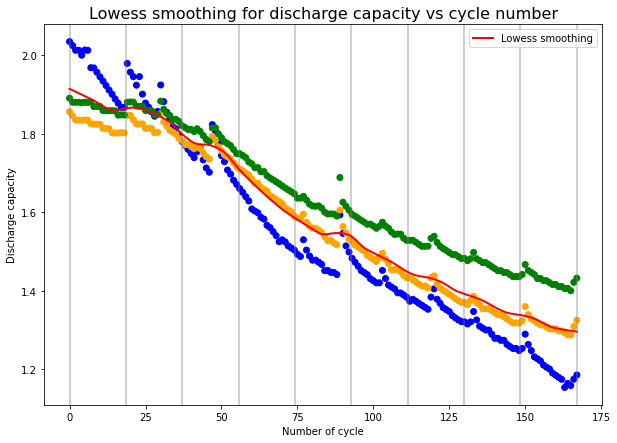

In [281]:
colors_battery = {'B0005': "orange", 'B0006': "blue", 'B0007': "green"}
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(df_discharge['cycle_id'], df_discharge['capacity'], c=df_discharge['battery_id'].apply(lambda x: colors_battery[x]))
ax.set_xlabel('Number of cycle')
ax.set_ylabel('Discharge capacity')
for knot in knots_list:
    ax.axvline(x=knot, color='grey', alpha=0.5)

lowess = sm.nonparametric.lowess
lowess_data = lowess(df_discharge['capacity'], df_discharge['cycle_id'], frac=0.1)
ax.plot(lowess_data[:, 0], lowess_data[:, 1], color='red', linewidth=2, label='Lowess smoothing')

ax.legend()
ax.set_title('Lowess smoothing for discharge capacity vs cycle number', fontsize=16)
fig.savefig('plots/lowess_smoothing_discharge_capacity.png')


Thanks to the lowess smoothing modeling from statsmodels library presented on the above plot it is possible to gain some insight into the approximate shape of the function that describes the relationship between the discharge capacity and the number of cycles. As can be seen on the plot, the function is not linear and it is not possible to fit a linear model to the data. Therefore, a more complex model is required to accurately describe the relationship between the discharge capacity and the number of cycles. One of the approaches that can be used to model this relationship is a spline model.

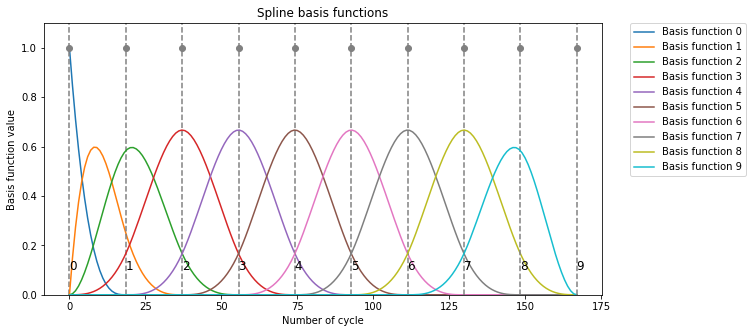

In [282]:
# Create spline matrix
B = create_spline_matrix(N, M, time, spline_order, knots_number)
B0 = B[0:M, :]

# Plot spline base
fig, ax = plt.subplots(figsize=(10, 5))
for i in range(knots_number+2):
    if i < knots_number:
        ax.plot(time, B0[:, i], label='Basis function ' + str(i))
        ax.axvline(knots_list[i], color='gray', linestyle='--')
        ax.text(s=str(i), x=knots_list[i], y=0.1, fontsize=12)
        ax.scatter(knots_list[i], 1, marker='o', color='gray', zorder=3)
ax.set_xlabel('Number of cycle')
ax.set_ylabel('Basis function value')
ax.set_ylim(0, 1.1)
ax.set_title('Spline basis functions')
# show legend on the right to the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
fig.savefig('plots/spline_basis_functions.png')

On the above plot the B-spline basis functions are presented. These functions play a crucial role in constructing the spline model. In this case, the spline order is set to 3, indicating a cubic spline, which means the basis functions are cubic polynomials.

The number of knots in the spline was specified as 10. Knots are the points where the polynomial pieces (segments) of the spline are connected, and they determine the flexibility and smoothness of the resulting curve. More knots generally lead to a more flexible, complex model, while fewer knots result in a smoother, simpler model.

# Priors

## Model 1

In [283]:
spline_ppc = CmdStanModel(stan_file='model/spline_centered_ppc.stan')
ppc_data = {'N': B.shape[0],
            'K': B.shape[1],
            'L': M,
            'x': B}
ppc_sample = spline_ppc.sample(data=ppc_data, seed=25072023)

INFO:cmdstanpy:compiling stan file /root/battery-pack-model-and-data/model/spline_centered_ppc.stan to exe file /root/battery-pack-model-and-data/model/spline_centered_ppc


INFO:cmdstanpy:compiled model executable: /root/battery-pack-model-and-data/model/spline_centered_ppc
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


In [284]:
ppc_df = ppc_sample.draws_pd()
ppc_df.describe()

,lp__,accept_stat__,sigma0,mu0,sigma,beta_raw[1],beta_raw[2],beta_raw[3],beta_raw[4],beta_raw[5],...,y_ppc[159],y_ppc[160],y_ppc[161],y_ppc[162],y_ppc[163],y_ppc[164],y_ppc[165],y_ppc[166],y_ppc[167],y_ppc[168]
count,4000.0,4000.0,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,...,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.0,0.0,0.253664,1.590239,10.051371,0.008161,0.018703,-0.006398,-0.007931,0.010877,...,1.521221,1.582739,1.291255,1.524274,1.289779,1.684772,1.736928,1.069922,1.470072,1.114358
std,0.0,0.0,0.097892,0.160154,10.224003,1.010466,0.997937,0.986608,0.987158,1.005221,...,14.280138,14.722440,14.119339,14.731623,14.565982,14.104508,14.550624,14.390408,14.432799,14.420790
min,0.0,0.0,0.000000,0.000000,0.000000,-3.736050,-2.938700,-3.517360,-3.567410,-3.672220,...,-112.265000,-156.198000,-134.064000,-140.056000,-107.700000,-163.881000,-134.480000,-114.631000,-122.019000,-175.052000
25%,0.0,0.0,0.187259,1.532337,2.852907,-0.672538,-0.655422,-0.671935,-0.662733,-0.661931,...,-2.287790,-1.989297,-2.297035,-2.167197,-2.452370,-2.001260,-1.943538,-2.474835,-2.231727,-2.262660
50%,0.0,0.0,0.253662,1.597905,6.833585,0.000000,0.034733,0.012208,0.000000,0.000000,...,1.561270,1.592780,1.523465,1.522350,1.517250,1.604480,1.630070,1.550800,1.533735,1.522985
75%,0.0,0.0,0.319268,1.666242,14.035250,0.679658,0.693416,0.648158,0.646588,0.691486,...,5.351000,5.359185,5.317448,5.219523,5.010288,5.378517,5.417230,5.249178,5.260603,5.071433
max,0.0,0.0,0.698296,1.974700,108.079000,3.318060,3.764150,3.604710,3.970680,3.650390,...,140.117000,137.583000,94.563200,136.963000,189.811000,122.576000,113.311000,136.009000,188.733000,121.593000


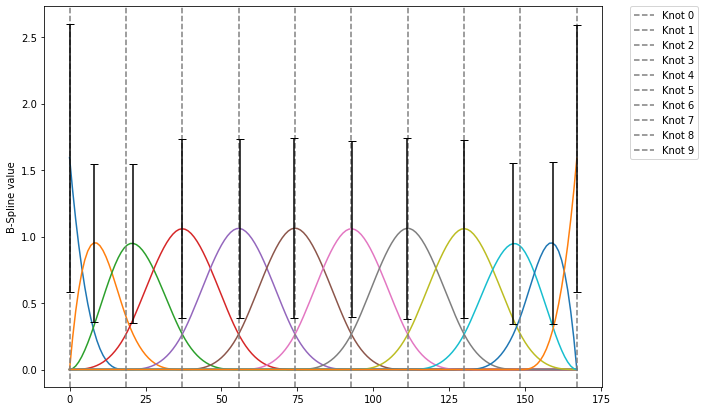

In [285]:
y_ppc = ppc_sample.stan_variable('y_ppc')
beta_ppc = ppc_sample.stan_variable('beta')
mu_ppc = ppc_sample.stan_variable('mu')

mu_beta = np.mean(beta_ppc, axis=0)
std_beta = np.std(beta_ppc, axis=0)

# Visualization of individual splines
B0 = B[0:M]
spline_components = np.matmul(B0, np.diag(mu_beta))
y_m = 0 * mu_beta

for i in range(len(y_m)):
    y_m[i] = max(spline_components[:, i].min(), spline_components[:, i].max(), key=abs)
x_m = np.argmax(np.abs(spline_components), axis=0)

fig, ax = plt.subplots(figsize=(10, 7))
for i in range(knots_number+2):
    ax.plot(time,(spline_components[:, i]), zorder=0)
    if i < knots_number:
        ax.axvline(knots_list[i], color='gray', linestyle='--', label='Knot ' + str(i))
    ax.errorbar(time[x_m[i]], y_m[i], yerr=2 * std_beta[i] * y_m[i], color='black', ls='none', capsize=4)
ax.set_ylabel('B-Spline value')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

/usr/local/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


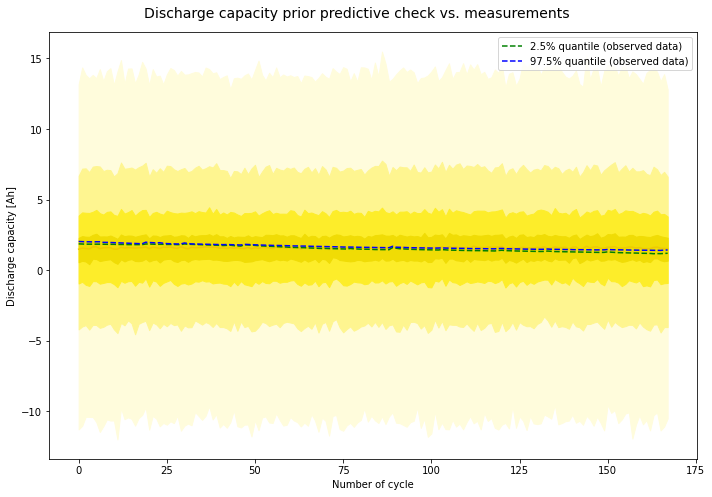

In [286]:
fig, ax_y = plt.subplots(1, 1, figsize=(10, 7), sharex=True)
fig.suptitle('Discharge capacity prior predictive check vs. measurements', fontsize=14)
ax_y = ribbon_plot(np.array(time), y_ppc, ax_y)
qs = get_quantiles(df_discharge.iloc[:N*M].pivot(index='cycle_id',columns='battery_id',values='capacity').values.T, [2.5, 50, 97.5])
ax_y.plot(time, qs[0, :], color='green', linestyle='--', label='2.5% quantile (observed data)')
ax_y.plot(time, qs[2, :], color='blue', linestyle='--', label='97.5% quantile (observed data)')
ax_y.set_ylabel('Discharge capacity [Ah]')
ax_y.set_xlabel('Number of cycle')
fig.tight_layout()
plt.legend()
plt.show()

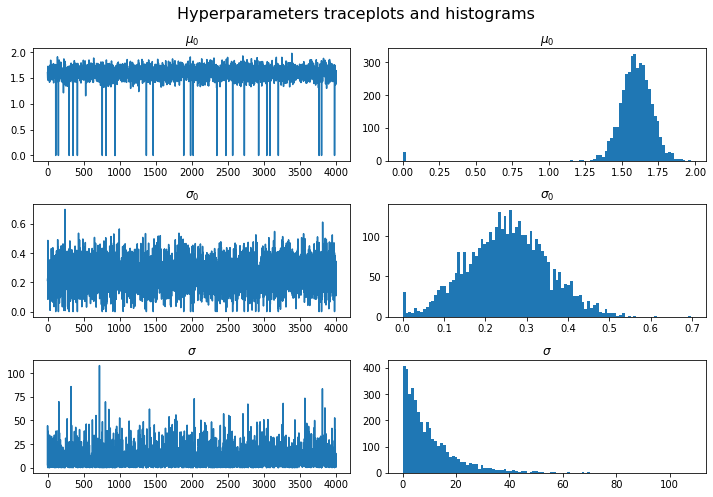

In [287]:
param_names = {'mu0': r'$\mu_0$', 'sigma0': r'$\sigma_0$', 'sigma': r'$\sigma$'}
fig, ax = plt.subplots(3, 2, figsize=(10, 7))
fig.suptitle('Hyperparameters traceplots and histograms', fontsize=16)
for i, param in enumerate(param_names.keys()):
    ax[i, 0].plot(ppc_sample.stan_variable(param))
    ax[i, 0].set_title(param_names[param])
    ax[i, 1].hist(ppc_sample.stan_variable(param), bins=100)
    ax[i, 1].set_title(param_names[param])
fig.tight_layout()
plt.show()

The priors selected seem to be generally O.K. The values are mostly in the correct range, but there is too much variance. We could combat it, but then we might end up with no fit at all, so let's stick with these values. Prior parameter values based on the professors' paper.

It does not capture the measurements' trend which might be worrying, but the ppc doesn't have real data for input.

## Model 2

In [288]:
qr_ppc_mod = CmdStanModel(stan_file="model/spline_qr_ppc.stan")
ppc_data_qr = {'N': B.shape[0],
               'K': B.shape[1],
               'L': M,
               'x': B}
qr_ppc_sample = qr_ppc_mod.sample(data=ppc_data_qr, seed=25072023)

INFO:cmdstanpy:found newer exe file, not recompiling


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


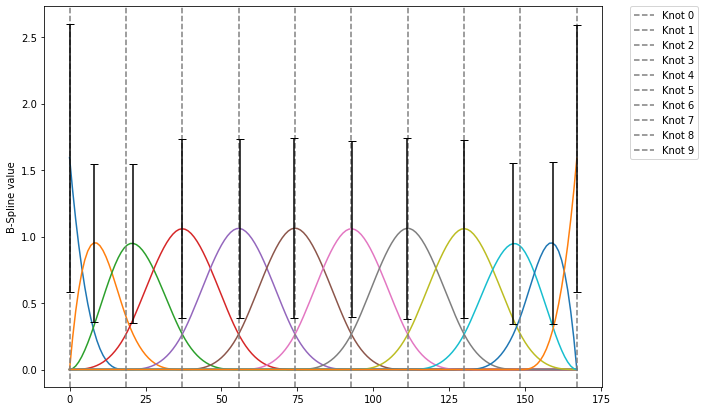

In [289]:
y_ppc = ppc_sample.stan_variable('y_ppc')
beta_ppc = ppc_sample.stan_variable('beta')
mu_ppc = ppc_sample.stan_variable('mu')

mu_beta = np.mean(beta_ppc, axis=0)
std_beta = np.std(beta_ppc, axis=0)

# Visualization of individual splines
B0 = B[0:M]
spline_components = np.matmul(B0, np.diag(mu_beta))
y_m = 0 * mu_beta

for i in range(len(y_m)):
    y_m[i] = max(spline_components[:, i].min(), spline_components[:, i].max(), key=abs)
x_m = np.argmax(np.abs(spline_components), axis=0)

fig, ax = plt.subplots(figsize=(10, 7))
for i in range(knots_number+2):
    ax.plot(time,(spline_components[:, i]), zorder=0)
    if i < knots_number:
        ax.axvline(knots_list[i], color='gray', linestyle='--', label='Knot ' + str(i))
    ax.errorbar(time[x_m[i]], y_m[i], yerr=2 * std_beta[i] * y_m[i], color='black', ls='none', capsize=4)
ax.set_ylabel('B-Spline value')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

/usr/local/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


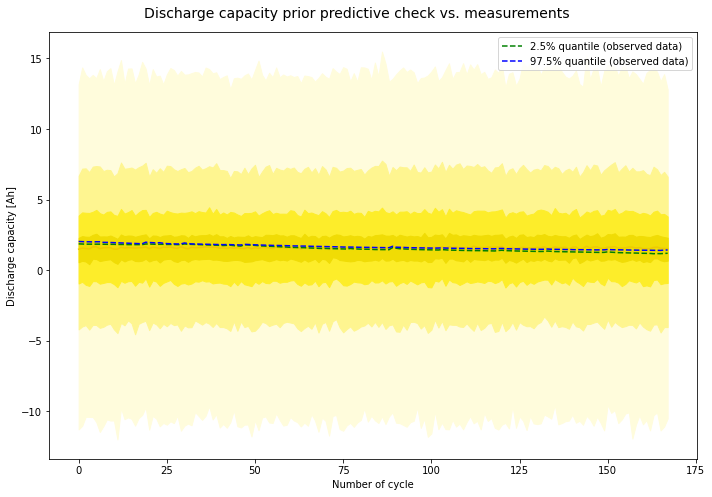

In [290]:
fig, ax_y = plt.subplots(1, 1, figsize=(10, 7), sharex=True)
fig.suptitle('Discharge capacity prior predictive check vs. measurements', fontsize=14)
ax_y = ribbon_plot(np.array(time), y_ppc, ax_y)
qs = get_quantiles(df_discharge.iloc[:N*M].pivot(index='cycle_id',columns='battery_id',values='capacity').values.T, [2.5, 50, 97.5])
ax_y.plot(time, qs[0, :], color='green', linestyle='--', label='2.5% quantile (observed data)')
ax_y.plot(time, qs[2, :], color='blue', linestyle='--', label='97.5% quantile (observed data)')
ax_y.set_ylabel('Discharge capacity [Ah]')
ax_y.set_xlabel('Number of cycle')
fig.tight_layout()
plt.legend()
plt.show()

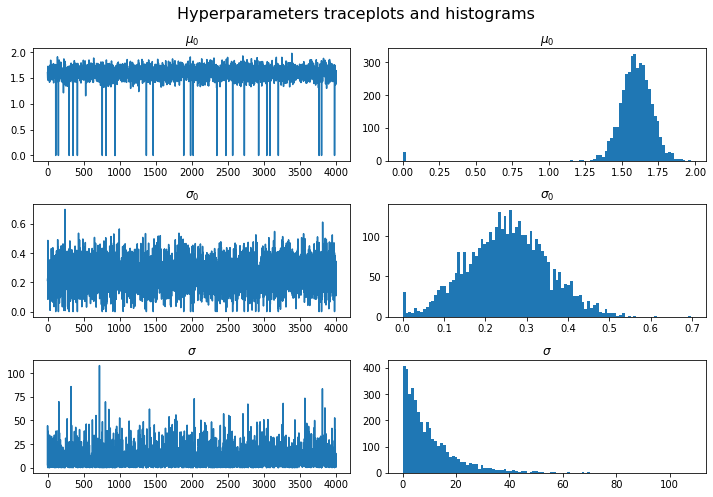

In [291]:
param_names = {'mu0': r'$\mu_0$', 'sigma0': r'$\sigma_0$', 'sigma': r'$\sigma$'}
fig, ax = plt.subplots(3, 2, figsize=(10, 7))
fig.suptitle('Hyperparameters traceplots and histograms', fontsize=16)
for i, param in enumerate(param_names.keys()):
    ax[i, 0].plot(ppc_sample.stan_variable(param))
    ax[i, 0].set_title(param_names[param])
    ax[i, 1].hist(ppc_sample.stan_variable(param), bins=100)
    ax[i, 1].set_title(param_names[param])
fig.tight_layout()
plt.show()

Once again, we got a generated dataset that encompases the measured data, so a fit is possible. We will proceed with these prior paramter estimates.

Similar to PPC for model 1 - the trend hasn't been captured by the simulated values, which could lead to problems, but we understand that risk.

We've assumed values from the professors' paper.

# Posterior analysis

## Posterior analysis for Model 1

In [292]:
spline_fit = CmdStanModel(stan_file='model/spline_centered_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [293]:
discharge_data = {'N': B.shape[0],
                  'K': B.shape[1],
                  'L': M,
                  'x': B,
                  'y': np.array(df_discharge['capacity'].values, dtype=np.float64)}

In [294]:
fit_discharge = spline_fit.sample(data=discharge_data, seed=25072023)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:01 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▋ | 00:01 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |█████████▌| 00:01 Iteration: 1800 / 2000 [ 90%]  (Sampling)



chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [295]:
fit_discharge.diagnose()

'Processing csv files: /tmp/tmpwrskizmp/spline_centered_fit-20230727155359_1.csv, /tmp/tmpwrskizmp/spline_centered_fit-20230727155359_2.csv, /tmp/tmpwrskizmp/spline_centered_fit-20230727155359_3.csv, /tmp/tmpwrskizmp/spline_centered_fit-20230727155359_4.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.\n'

No issue with sampling. The model converged well.

In [296]:
y_pred = fit_discharge.stan_variable('y_pred')
beta_healthy = fit_discharge.stan_variable('beta')
mu = fit_discharge.stan_variable('mu')

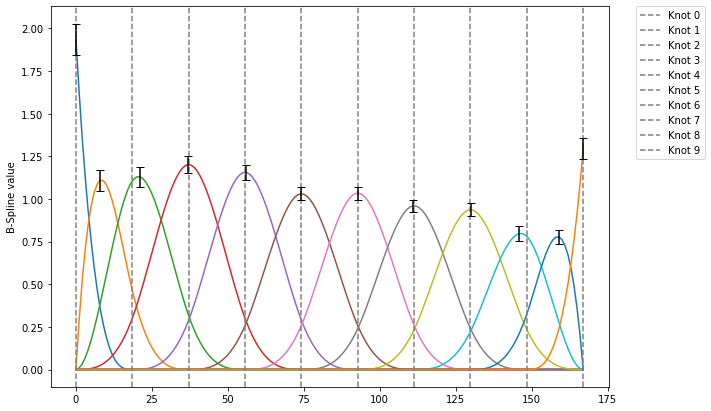

In [297]:
mu_beta = np.mean(beta_healthy, axis=0)
std_beta = np.std(beta_healthy, axis=0)

# Visualization of individual splines
B0 = B[0:M]
spline_components = np.matmul(B0, np.diag(mu_beta))
y_m = 0*mu_beta

for i in range(len(y_m)):
    y_m[i] = max(spline_components[:, i].min(), spline_components[:, i].max(), key=abs)
x_m = np.argmax(np.abs(spline_components), axis=0)

fig, ax = plt.subplots(figsize=(10, 7))
for i in range(knots_number+2):
    ax.plot(time,(spline_components[:, i]), zorder=0)
    if i < knots_number:
        ax.axvline(knots_list[i], color='gray', linestyle='--', label='Knot ' + str(i))
    ax.errorbar(time[x_m[i]], y_m[i], yerr=2*std_beta[i]*y_m[i], color='black', ls='none', capsize=4)
ax.set_ylabel('B-Spline value')
# show labels on the right to the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
fig.savefig('plots/spline_components_qr.png')
plt.show()

### Visualization of predicted values

/usr/local/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


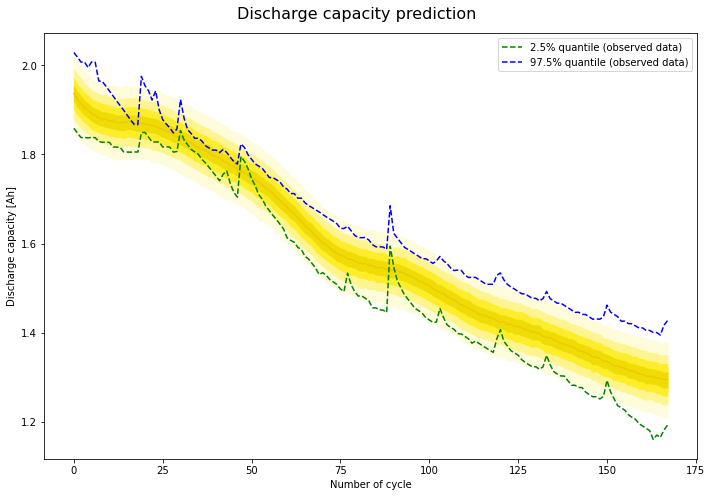

In [298]:
fig, ax_y = plt.subplots(1, 1, figsize=(10, 7), sharex=True)
fig.suptitle('Discharge capacity prediction', fontsize=16)
ax_y = ribbon_plot(np.array(time), y_pred, ax_y)
qs = get_quantiles(df_discharge.iloc[:N*M].pivot(index='cycle_id',columns='battery_id',values='capacity').values.T, [2.5, 50, 97.5])
ax_y.plot(time, qs[0, :], color='green', linestyle='--', label='2.5% quantile (observed data)')
ax_y.plot(time, qs[2, :], color='blue', linestyle='--', label='97.5% quantile (observed data)')
ax_y.set_ylabel('Discharge capacity [Ah]')
ax_y.set_xlabel('Number of cycle')
fig.tight_layout()
plt.legend()
plt.show()
fig.savefig('plots/discharge_capacity_fit.png')

/usr/local/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


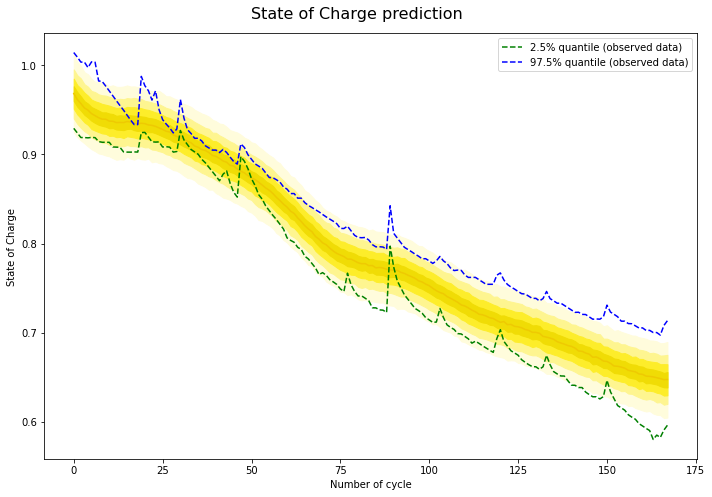

In [299]:
rated_capacity = 2.0
# SoC calculation as a ratio of discharge capacity to rated capacity
fig, ax_y = plt.subplots(1, 1, figsize=(10, 7), sharex=True)
fig.suptitle('State of Charge prediction', fontsize=16)
ax_y = ribbon_plot(np.array(time), y_pred/rated_capacity, ax_y)
qs = get_quantiles(df_discharge.iloc[:N*M].pivot(index='cycle_id',columns='battery_id',values='capacity').values.T/rated_capacity, [2.5, 50, 97.5])
ax_y.plot(time, qs[0, :], color='green', linestyle='--', label='2.5% quantile (observed data)')
ax_y.plot(time, qs[2, :], color='blue', linestyle='--', label='97.5% quantile (observed data)')
ax_y.set_ylabel('State of Charge')
ax_y.set_xlabel('Number of cycle')
fig.tight_layout()
plt.legend()
plt.show()
fig.savefig('plots/state_of_charge_fit.png')


In [300]:
# predicted values summary
pred_y_summary = az.summary(fit_discharge, var_names=['y_pred'], round_to=2, hdi_prob=0.95)
# save predicted values summary to csv file
pred_y_summary.to_csv('results/predicted_values_summary.csv')
pred_y_summary

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
y_pred[0],1.94,0.07,1.81,2.07,0.0,0.0,3715.37,3856.72,1.0
y_pred[1],1.92,0.07,1.79,2.05,0.0,0.0,4111.75,4147.64,1.0
y_pred[2],1.91,0.07,1.79,2.04,0.0,0.0,3983.23,3795.51,1.0
y_pred[3],1.90,0.06,1.79,2.04,0.0,0.0,4115.80,3830.55,1.0
y_pred[4],1.90,0.06,1.78,2.02,0.0,0.0,3738.36,3852.93,1.0
...,...,...,...,...,...,...,...,...,...
y_pred[163],1.30,0.06,1.18,1.42,0.0,0.0,4098.93,3851.28,1.0
y_pred[164],1.30,0.06,1.17,1.42,0.0,0.0,3806.87,3157.14,1.0
y_pred[165],1.30,0.06,1.17,1.42,0.0,0.0,3948.19,3982.69,1.0
y_pred[166],1.29,0.06,1.17,1.42,0.0,0.0,3915.71,4097.17,1.0


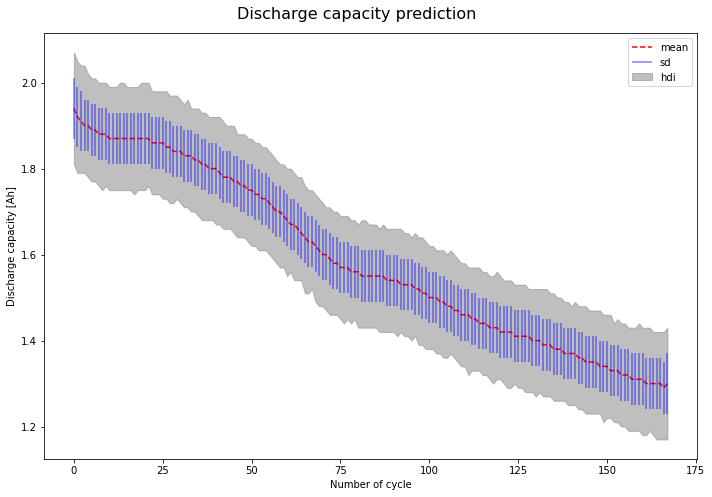

In [301]:
# Plot mean with sd of predicted values and hdi
fig, ax_y = plt.subplots(1, 1, figsize=(10, 7), sharex=True)
fig.suptitle('Discharge capacity prediction', fontsize=16)
ax_y.plot(time, pred_y_summary['mean'], color='red', linestyle='--', label='mean')
# plot sd as vertical lines
ax_y.vlines(time, pred_y_summary['mean']+pred_y_summary['sd'], pred_y_summary['mean']-pred_y_summary['sd'], color='blue', alpha=0.5, label='sd')
# plot hdi
ax_y.fill_between(time, pred_y_summary['hdi_2.5%'], pred_y_summary['hdi_97.5%'], color='gray', alpha=0.5, label='hdi')
ax_y.set_ylabel('Discharge capacity [Ah]')
ax_y.set_xlabel('Number of cycle')
fig.tight_layout()
plt.legend()
plt.show()
fig.savefig('plots/discharge_capacity_fit_mean_sd_hdi.png')

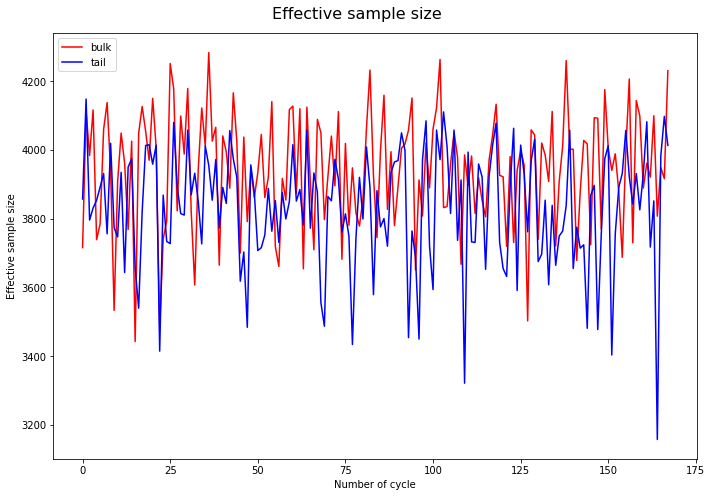

In [302]:
# Plot ESS bulk and tail
fig, ax = plt.subplots(1, 1, figsize=(10, 7), sharex=True)
fig.suptitle('Effective sample size', fontsize=16)
ax.plot(time, pred_y_summary['ess_bulk'], color='red', linestyle='-', label='bulk')
ax.plot(time, pred_y_summary['ess_tail'], color='blue', linestyle='-', label='tail')
ax.set_ylabel('Effective sample size')
ax.set_xlabel('Number of cycle')
fig.tight_layout()
plt.legend()
plt.show()
fig.savefig('plots/ess_bulk_tail.png')

In [303]:
# min, max of parameters in predicted values
for param in pred_y_summary.columns:
    print(param + ' min: ' + str(pred_y_summary[param].min()) + ' max: ' + str(pred_y_summary[param].max()))

mean min: 1.29 max: 1.94
sd min: 0.06 max: 0.07
hdi_2.5% min: 1.17 max: 1.81
hdi_97.5% min: 1.42 max: 2.07
mcse_mean min: 0.0 max: 0.0
mcse_sd min: 0.0 max: 0.0
ess_bulk min: 3441.87 max: 4282.86
ess_tail min: 3157.14 max: 4147.64
r_hat min: 1.0 max: 1.0


### Interpretation of the predicted values
1. The range of mean values:
   - Minimum "mean" value: 1.29
   - Maximum "mean" value: 1.94

2. The range of standard deviation values:
   - Minimum "sd" value: 0.06
   - Maximum "sd" value: 0.07

3. The range of "hdi_2.5%" values:
   - Minimum "hdi_2.5%" value: 1.17
   - Maximum "hdi_2.5%" value: 1.81

4. The range of "hdi_97.5%" values:
   - Minimum "hdi_97.5%" value: 1.42
   - Maximum "hdi_97.5%" value: 2.07

5. The range of effective sample size for bulk values:
   - Minimum "ess_bulk" value: 3441.87
   - Maximum "ess_bulk" value: 4282.86

6. The range of effective sample size for tail values:
   - Minimum "ess_tail" value: 3157.14
   - Maximum "ess_tail" value: 4147.64

7. All the values of "mcse_mean" and "mcse_sd" are 0.0 for all prediction values, which indicates that the MCMC algorithm produced very precise estimates of the mean and standard deviation.

8. The "r_hat" (potential scale reduction factor) values for all y_pred are 1.0, indicating convergence and consistency.

In the summary for that model as well the very large effective sample sizes (ESS) were obtained meaning that well MCMC algorithm have mixed well and the posterior distribution is reliable.

Predicted values produced by this model as well as parameters of those values are very similar to the ones produced by the Model 2.

### Visualization of hyperparameters

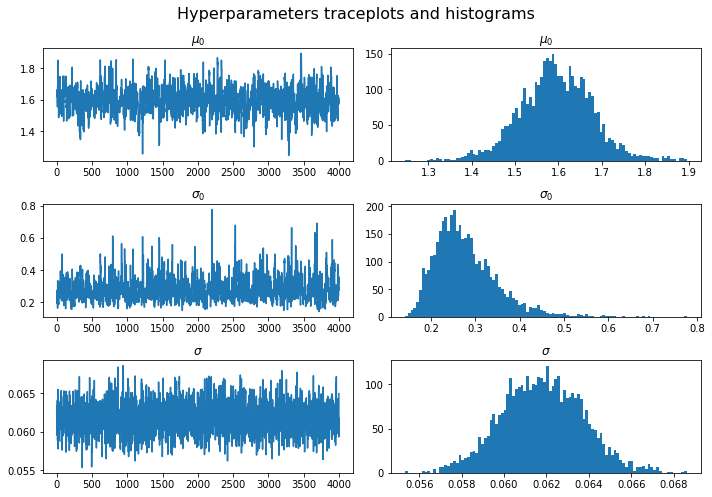

In [304]:
param_names = {'mu0': r'$\mu_0$', 'sigma0': r'$\sigma_0$', 'sigma': r'$\sigma$'}
fig, ax = plt.subplots(3, 2, figsize=(10, 7))
fig.suptitle('Hyperparameters traceplots and histograms', fontsize=16)
for i, param in enumerate(param_names.keys()):
    ax[i, 0].plot(fit_discharge.stan_variable(param))
    ax[i, 0].set_title(param_names[param])
    ax[i, 1].hist(fit_discharge.stan_variable(param), bins=100)
    ax[i, 1].set_title(param_names[param])
fig.tight_layout()
plt.show()
fig.savefig('plots/hyperparameters_traceplots_and_histograms.png')

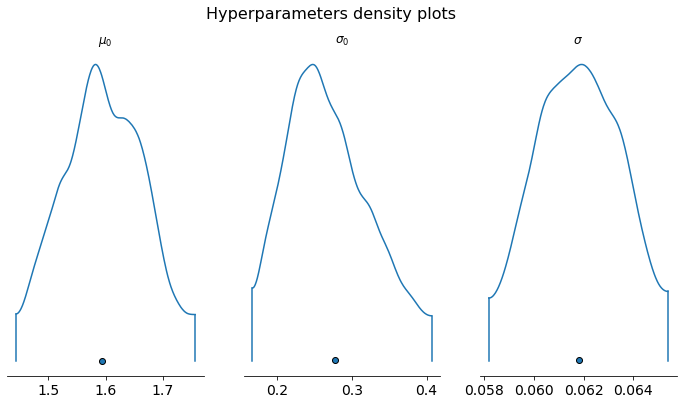

In [305]:
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
fig.suptitle('Hyperparameters density plots', fontsize=16)
ax = az.plot_density(fit_discharge, var_names=[*param_names], ax=ax)
ax[0].set_title(param_names['mu0'])
ax[1].set_title(param_names['sigma0'])
ax[2].set_title(param_names['sigma'])
plt.show()
fig.savefig('plots/hyperparameters_density_plots.png')


In [306]:
# hyperparameters summary for the fit model
hyperparameters_summary = az.summary(fit_discharge, var_names=['mu0', 'sigma0', 'sigma'], round_to=2, hdi_prob=0.95)
# save hyperparameters summary to csv file
hyperparameters_summary.to_csv('results/hyperparameters_summary.csv')
hyperparameters_summary

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu0,1.59,0.08,1.43,1.76,0.0,0.0,529.60,542.59,1.01
sigma0,0.28,0.07,0.16,0.41,0.0,0.0,587.98,874.63,1.01
sigma,0.06,0.00,0.06,0.07,0.0,0.0,1925.20,2051.08,1.00


### Interpretation of the hyperparameters
- $\mu_0$ - Hyperparameter for the spline prior mean (intercept term).
  - The posterior mean estimate is 1.59 with standard deviation of 0.08. 
  - The 95% Highest Density Interval (HDI) ranges from 1.43 to 1.76, which means that the true value of the hyperparameter $\mu_0$ has a 95% probability of being in this interval. 
  - The effective sample size (ESS) for bulk is 529.6 and for tail 542.59.
  - The potential scale reduction factor (R-hat) is close to 1, indicating good convergence.
- $\sigma_0$ - Hyperparameter for the spline prior standard deviation.
  - The posterior mean estimate is 0.28 with standard deviation of 0.07.
  - The 95% Highest Density Interval (HDI) ranges from 0.16 to 0.41.
  - The effective sample size (ESS) for bulk is 587.98 and for tail 874.63.
  - The potential scale reduction factor (R-hat) is close to 1, indicating good convergence.
- $\sigma$ - Error scale (standard deviation of the error term).
  - The posterior mean estimate is 0.06 with standard deviation of around 0.00.
  - The 95% Highest Density Interval (HDI) ranges from 0.06 to 0.07.
  - The effective sample size (ESS) for bulk is 1925.20 and for tail 2051.08.
  - The potential scale reduction factor (R-hat) is 1, indicating great convergence.

The "mcse_mean" and "mcse_sd" columns shows the standard error of the posterior mean and standard deviation estimates for the Markov chain Monte Carlo (MCMC) samples. As can be seen in the table above, the standard errors are close to 0 for all parameters, potentially due to the large effective sample size (ESS) for all parameters. It is indicating good mixing and convergence of the MCMC algorithm as well as relability of the MCMC samples. This can be further confirmed by the low values of the potential scale reduction factor (R-hat), which is close to 1 for all parameters, indicating good convergence.

## Posterior analysis for Model 2

In [307]:
spline_qr_fit = CmdStanModel(stan_file='model/spline_qr_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [308]:
discharge_qr_data = {'N': B.shape[0],
                     'K': B.shape[1],
                     'L': M,
                     'x': B,
                     'y': np.array(df_discharge['capacity'].values, dtype=np.float64)}

In [309]:
fit_qr_discharge = spline_qr_fit.sample(data=discharge_qr_data, seed=25072023)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status







chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [310]:
fit_qr_discharge.diagnose()

'Processing csv files: /tmp/tmpwrskizmp/spline_qr_fit-20230727155404_1.csv, /tmp/tmpwrskizmp/spline_qr_fit-20230727155404_2.csv, /tmp/tmpwrskizmp/spline_qr_fit-20230727155404_3.csv, /tmp/tmpwrskizmp/spline_qr_fit-20230727155404_4.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.\n'

No issue with sampling. The model converged well.

In [311]:
y_pred_qr = fit_qr_discharge.stan_variable('y_pred')
beta_healthy_qr = fit_qr_discharge.stan_variable('beta')
mu_qr = fit_qr_discharge.stan_variable('mu')

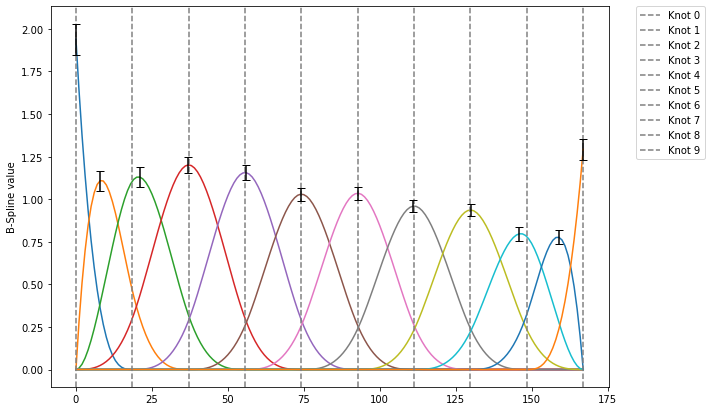

In [312]:
mu_beta = np.mean(beta_healthy_qr, axis=0)
std_beta = np.std(beta_healthy_qr, axis=0)

# Visualization of individual splines
B0 = B[0:M]
spline_components = np.matmul(B0, np.diag(mu_beta))
y_m = 0*mu_beta

for i in range(len(y_m)):
    y_m[i] = max(spline_components[:, i].min(), spline_components[:, i].max(), key=abs)
x_m = np.argmax(np.abs(spline_components), axis=0)

fig, ax = plt.subplots(figsize=(10, 7))
for i in range(knots_number+2):
    ax.plot(time,(spline_components[:, i]), zorder=0)
    if i < knots_number:
        ax.axvline(knots_list[i], color='gray', linestyle='--', label='Knot ' + str(i))
    ax.errorbar(time[x_m[i]], y_m[i], yerr=2*std_beta[i]*y_m[i], color='black', ls='none', capsize=4)
ax.set_ylabel('B-Spline value')
# show labels on the right to the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
fig.savefig('plots/spline_components_qr_fit.png')
plt.show()

### Visualization of predicted values

/usr/local/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


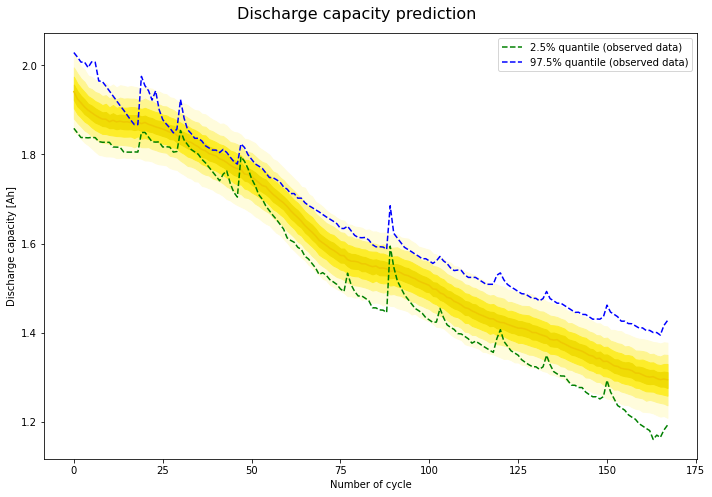

In [313]:
fig, ax_y = plt.subplots(1, 1, figsize=(10, 7), sharex=True)
fig.suptitle('Discharge capacity prediction', fontsize=16)
ax_y = ribbon_plot(np.array(time), y_pred_qr, ax_y)
qs = get_quantiles(df_discharge.iloc[:N*M].pivot(index='cycle_id',columns='battery_id',values='capacity').values.T, [2.5, 50, 97.5])
ax_y.plot(time, qs[0, :], color='green', linestyle='--', label='2.5% quantile (observed data)')
ax_y.plot(time, qs[2, :], color='blue', linestyle='--', label='97.5% quantile (observed data)')
ax_y.set_ylabel('Discharge capacity [Ah]')
ax_y.set_xlabel('Number of cycle')
fig.tight_layout()
plt.legend()
plt.show()
fig.savefig('plots/discharge_capacity_fit_qr.png')

/usr/local/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


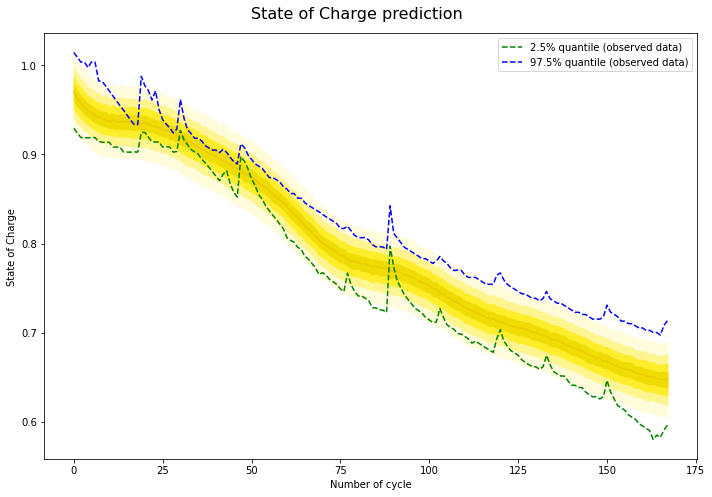

In [314]:
rated_capacity = 2.0
# SoC calculation as a ratio of discharge capacity to rated capacity
fig, ax_y = plt.subplots(1, 1, figsize=(10, 7), sharex=True)
fig.suptitle('State of Charge prediction', fontsize=16)
ax_y = ribbon_plot(np.array(time), y_pred_qr/rated_capacity, ax_y)
qs = get_quantiles(df_discharge.iloc[:N*M].pivot(index='cycle_id',columns='battery_id',values='capacity').values.T/rated_capacity, [2.5, 50, 97.5])
ax_y.plot(time, qs[0, :], color='green', linestyle='--', label='2.5% quantile (observed data)')
ax_y.plot(time, qs[2, :], color='blue', linestyle='--', label='97.5% quantile (observed data)')
ax_y.set_ylabel('State of Charge')
ax_y.set_xlabel('Number of cycle')
fig.tight_layout()
plt.legend()
plt.show()
fig.savefig('plots/state_of_charge_fit_qr.png')

In [315]:
# predicted values summary
pred_y_summary_qr = az.summary(fit_qr_discharge, var_names=['y_pred'], round_to=2, hdi_prob=0.95)
# save predicted values summary to csv file
pred_y_summary_qr.to_csv('results/predicted_values_summary_qr.csv')
pred_y_summary_qr


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
y_pred[0],1.94,0.07,1.81,2.07,0.0,0.0,4443.33,4012.82,1.0
y_pred[1],1.93,0.06,1.80,2.05,0.0,0.0,4169.56,3964.55,1.0
y_pred[2],1.92,0.06,1.80,2.05,0.0,0.0,4273.91,4099.43,1.0
y_pred[3],1.91,0.06,1.78,2.03,0.0,0.0,4318.72,3968.39,1.0
y_pred[4],1.90,0.06,1.78,2.02,0.0,0.0,4038.26,3890.48,1.0
...,...,...,...,...,...,...,...,...,...
y_pred[163],1.30,0.06,1.18,1.42,0.0,0.0,3991.02,4041.45,1.0
y_pred[164],1.30,0.06,1.17,1.42,0.0,0.0,4053.77,3499.31,1.0
y_pred[165],1.29,0.06,1.17,1.42,0.0,0.0,4110.79,3849.86,1.0
y_pred[166],1.30,0.06,1.18,1.43,0.0,0.0,3998.71,3852.87,1.0


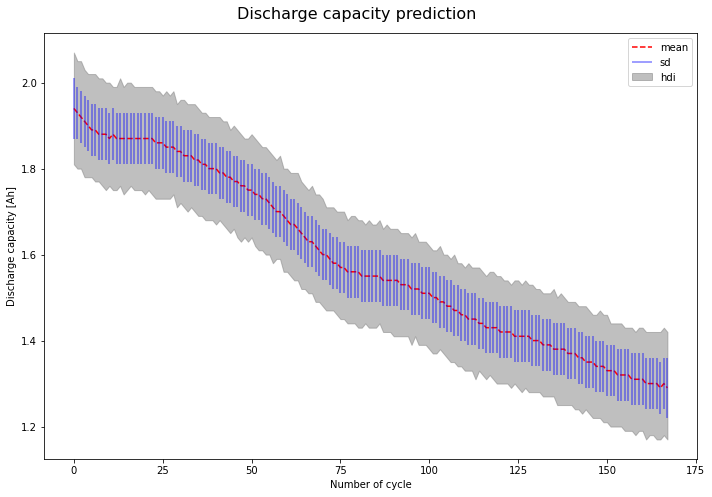

In [316]:
# Plot mean with sd of predicted values and hdi
fig, ax_y = plt.subplots(1, 1, figsize=(10, 7), sharex=True)
fig.suptitle('Discharge capacity prediction', fontsize=16)
ax_y.plot(time, pred_y_summary_qr['mean'], color='red', linestyle='--', label='mean')
# plot sd as vertical lines
ax_y.vlines(time, pred_y_summary_qr['mean']+pred_y_summary_qr['sd'], pred_y_summary_qr['mean']-pred_y_summary_qr['sd'], color='blue', alpha=0.5, label='sd')
# plot hdi
ax_y.fill_between(time, pred_y_summary_qr['hdi_2.5%'], pred_y_summary_qr['hdi_97.5%'], color='gray', alpha=0.5, label='hdi')
ax_y.set_ylabel('Discharge capacity [Ah]')
ax_y.set_xlabel('Number of cycle')
fig.tight_layout()
plt.legend()
plt.show()
fig.savefig('plots/discharge_capacity_fit_mean_sd_hdi_qr.png')

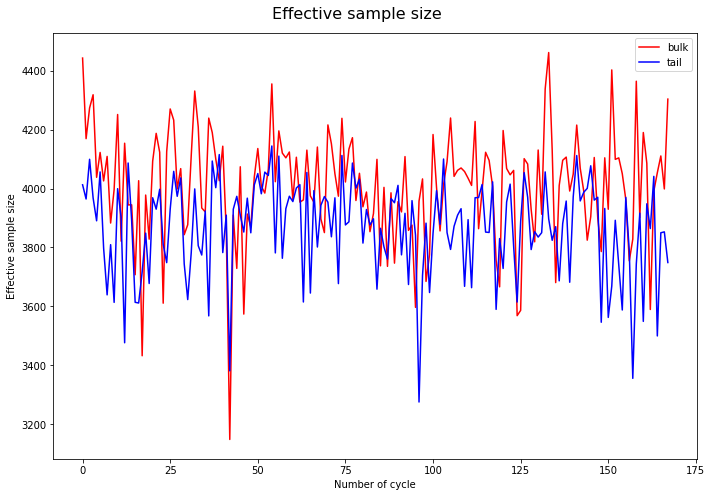

In [317]:
# Plot ESS bulk and tail
fig, ax = plt.subplots(1, 1, figsize=(10, 7), sharex=True)
fig.suptitle('Effective sample size', fontsize=16)
ax.plot(time, pred_y_summary_qr['ess_bulk'], color='red', linestyle='-', label='bulk')
ax.plot(time, pred_y_summary_qr['ess_tail'], color='blue', linestyle='-', label='tail')
ax.set_ylabel('Effective sample size')
ax.set_xlabel('Number of cycle')
fig.tight_layout()
plt.legend()
plt.show()
fig.savefig('plots/ess_bulk_tail_qr.png')

In [318]:
# min, max of parameters in predicted values
for param in pred_y_summary_qr.columns:
    print(param + ' min: ' + str(pred_y_summary_qr[param].min()) + ', max: ' + str(pred_y_summary_qr[param].max()))

mean min: 1.29, max: 1.94
sd min: 0.06, max: 0.07
hdi_2.5% min: 1.17, max: 1.81
hdi_97.5% min: 1.42, max: 2.07
mcse_mean min: 0.0, max: 0.0
mcse_sd min: 0.0, max: 0.0
ess_bulk min: 3147.68, max: 4462.07
ess_tail min: 3274.86, max: 4144.62
r_hat min: 1.0, max: 1.0


### Interpretation of the predicted values
1. The range of mean values:
   - Minimum "mean" value: 1.29
   - Maximum "mean" value: 1.94

2. The range of standard deviation values:
   - Minimum "sd" value: 0.06
   - Maximum "sd" value: 0.07

3. The range of "hdi_2.5%" values:
   - Minimum "hdi_2.5%" value: 1.17
   - Maximum "hdi_2.5%" value: 1.81

4. The range of "hdi_97.5%" values:
   - Minimum "hdi_97.5%" value: 1.42
   - Maximum "hdi_97.5%" value: 2.07

5. The range of effective sample size for bulk values:
   - Minimum "ess_bulk" value: 3147.68
   - Maximum "ess_bulk" value: 4462.07

6. The range of effective sample size for tail values:
   - Minimum "ess_tail" value: 3274.86
   - Maximum "ess_tail" value: 4144.62

7. All the values of "mcse_mean" and "mcse_sd" are 0.0 for all prediction values, which indicates that the MCMC algorithm produced very precise estimates of the mean and standard deviation.

8. The "r_hat" (potential scale reduction factor) values for all y_pred are 1.0, indicating convergence and consistency.

In the summary for that model the very large effective sample sizes (ESS) were obtained meaning that well MCMC algorithm have mixed well and the posterior distribution is reliable.

### Visualization of hyperparameters

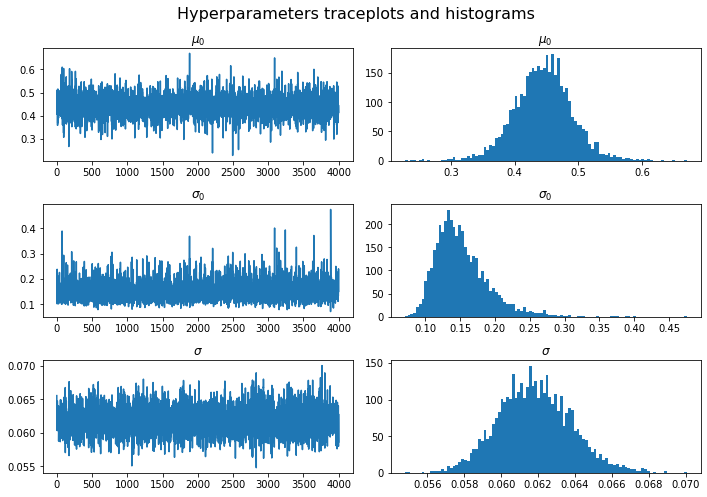

In [319]:
param_names = {'mu0': r'$\mu_0$', 'sigma0': r'$\sigma_0$', 'sigma': r'$\sigma$'}
fig, ax = plt.subplots(3, 2, figsize=(10, 7))
fig.suptitle('Hyperparameters traceplots and histograms', fontsize=16)
for i, param in enumerate(param_names.keys()):
    ax[i, 0].plot(fit_qr_discharge.stan_variable(param))
    ax[i, 0].set_title(param_names[param])
    ax[i, 1].hist(fit_qr_discharge.stan_variable(param), bins=100)
    ax[i, 1].set_title(param_names[param])
fig.tight_layout()
plt.show()
fig.savefig('plots/hyperparameters_traceplots_and_histograms_qr.png')

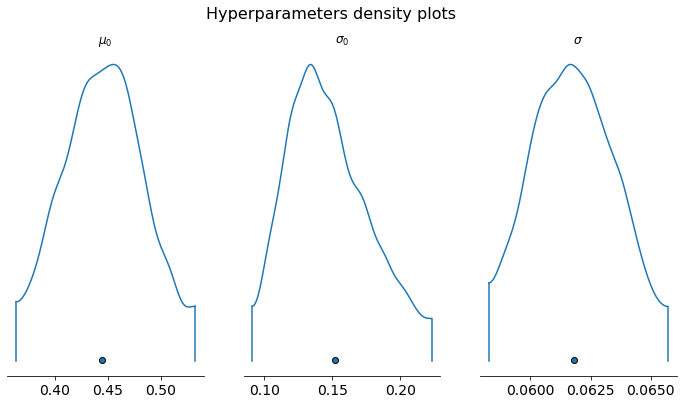

In [320]:
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
fig.suptitle('Hyperparameters density plots', fontsize=16)
ax = az.plot_density(fit_qr_discharge, var_names=[*param_names], ax=ax)
ax[0].set_title(param_names['mu0'])
ax[1].set_title(param_names['sigma0'])
ax[2].set_title(param_names['sigma'])
plt.show()
fig.savefig('plots/hyperparameters_density_plots_qr.png')

In [321]:
# hyperparameters summary for the fit model
hyperparameters_summary = az.summary(fit_qr_discharge, var_names=['mu0', 'sigma0', 'sigma'], round_to=2, hdi_prob=0.95)
# save hyperparameters summary to csv file
hyperparameters_summary.to_csv('results/hyperparameters_summary_qr.csv')
hyperparameters_summary

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu0,0.44,0.05,0.35,0.53,0.0,0.0,3625.84,2403.92,1.0
sigma0,0.15,0.04,0.09,0.23,0.0,0.0,3775.50,2713.83,1.0
sigma,0.06,0.00,0.06,0.07,0.0,0.0,5288.00,3029.20,1.0


#### Interpretation of the hyperparameters
- $\mu_0$ - Hyperparameter for the spline prior mean (intercept term).
  - The posterior mean estimate is 0.44 with standard deviation of 0.05. 
  - The 95% Highest Density Interval (HDI) ranges from 0.35 to 0.53, which means that the true value of the hyperparameter $\mu_0$ has a 95% probability of being in this interval. 
  - The effective sample size (ESS) for bulk is 3625.84 and for tail 2403.92.
  - The potential scale reduction factor (R-hat) is 1, indicating great convergence.
- $\sigma_0$ - Hyperparameter for the spline prior standard deviation.
  - The posterior mean estimate is 0.15 with standard deviation of 0.04.
  - The 95% Highest Density Interval (HDI) ranges from 0.09 to 0.23.
  - The effective sample size (ESS) for bulk is 3775.50 and for tail 2713.83.
  - The potential scale reduction factor (R-hat) is 1, indicating great convergence.
- $\sigma$ - Error scale (standard deviation of the error term).
  - The posterior mean estimate is 0.06 with standard deviation of around 0.00.
  - The 95% Highest Density Interval (HDI) ranges from 0.06 to 0.07.
  - The effective sample size (ESS) for bulk is 5288.00 and for tail 3029.20.
  - The potential scale reduction factor (R-hat) is 1, indicating great convergence.

For this model as well we achieve the "mcse_mean" and "mcse_sd" values close to 0 for all parameters. It is worth to notice that for this model the effective sample size (ESS) for all parameters is noticibly higher than for the previous model. Higher ESS values generally imply more reliable and precise estimates of the posterior distribution for the corresponding parameters. It also suggests that the MCMC chain has explored the parameter space more thoroughly, resulting in even better convergence and mixing. The R-hat values are equal to 1 for all parameters, indicating great convergence.

Summarizing the MCMC algorithm in the second model has been more efficient and effective in sampling the posterior distribution and obtaining reliable parameter estimates compared to the first model.

# Model comparison

In [322]:
if_data_centralized = az.from_cmdstanpy(fit_discharge, log_likelihood='log_likelihood')
if_data_qr = az.from_cmdstanpy(fit_qr_discharge, log_likelihood='log_likelihood')

In [323]:
models = {'Model spline centralized' : if_data_centralized, 'Model spline QR' : if_data_qr}

In [324]:
models_loo = az.compare(compare_dict=models, ic='loo')
models_loo

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Model spline QR,0,188.826255,7.200453,0.000000,1.000000e+00,7.324369,0.000000,False,log
Model spline centralized,1,187.845658,7.265215,0.980597,1.110223e-16,7.394114,0.099495,False,log


1. Model spline 1 - spline centralized:
   - Rank: 1
   - LOO (Leave-One-Out) Information Criterion: 187.845658
   - p_loo (Effective number of parameters for LOO): 7.265215
   - d_loo (Difference in LOO between models): 0.980597
   - Weight: 1.110223e-16
   - SE (Standard Error) of LOO: 7.394114
   - dSE (Standard Error of the Difference in LOO): 0.099495
   - Warning: False
   - LOO Scale: log

2. Model 2 - spline qr decomposition:
   - Rank: 0
   - LOO (Leave-One-Out) Information Criterion: 188.826255
   - p_loo (Effective number of parameters for LOO): 7.200453
   - d_loo (Difference in LOO between models): 0.000000
   - Weight: 0.000000
   - SE (Standard Error) of LOO: 7.324369
   - dSE (Standard Error of the Difference in LOO): 0.000000
   - Warning: False
   - LOO Scale: log

Model 1 based on the LOO criterion is better than Model 2, since it has higher rank and lower LOO Information Criterion value.

In [325]:
models_waic = az.compare(compare_dict=models, ic='waic')
models_waic

/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Model spline QR,0,188.855891,7.170818,0.00000,1.0,7.320761,0.000000,True,log
Model spline centralized,1,187.874341,7.236532,0.98155,0.0,7.390271,0.101239,True,log


The WAIC method completed with some warnings, which might mean ELPD computation might not be accurate.
1. Model 1 - spline centralized:
   - Rank: 1
   - WAIC: 187.874341
   - p_WAIC: 7.236532
   - d_WAIC: 0.98155
   - Weight: 0.0
   - SE (Standard Error): 7.390271
   - dSE (Standard Error of the Difference): 0.101239
   - Warning: True
   - WAIC Scale: log

2. Model 2 - spline QR decomposition:
   - Rank: 0
   - WAIC: 188.855891
   - p_WAIC: 7.170818
   - d_WAIC: 0.00000
   - Weight: 1.0
   - SE (Standard Error): 7.320761
   - dSE (Standard Error of the Difference): 0.000000
   - Warning: True
   - WAIC Scale: log

Model 1 slightly outperforms Model 2 based on the WAIC comparison, as it has a lower WAIC value and a higher rank.

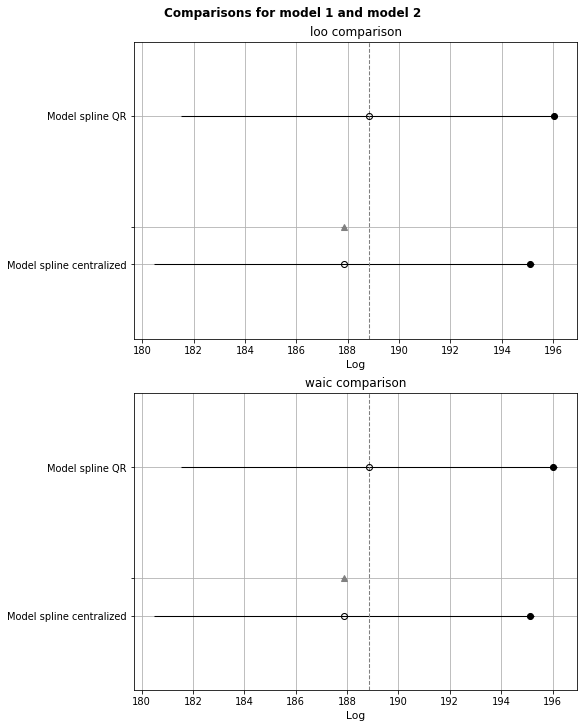

In [326]:
fig, ax = plt.subplots(2, 1, figsize=(8, 10), constrained_layout=True)
az.plot_compare(models_loo, ax=ax[0], insample_dev=True)
az.plot_compare(models_waic, ax=ax[1], insample_dev=True)
ax[0].set_title('loo comparison')
ax[0].grid()
ax[1].set_title('waic comparison')
ax[1].grid()
plt.suptitle("Comparisons for model 1 and model 2", fontweight='bold')
plt.show()

## Comments on the comparison results

The results of the model comparison are consistent with the results of the posterior analysis. Model 1 has a lower LOO Information Criterion value and a higher rank, indicating that it is a better model than Model 2. The WAIC comparison also shows that Model 1 has a lower WAIC value and a higher rank, which is consistent with the results of the LOO comparison. 

Both authors consider Model 1 to be slightly better.

# Final comments and conclusions

Both models have accomplished the task, with the centered parameter method performing slightly better. I believe both of them can be refined enough to be able to perform predictions with good probability. The centered parameter model may be found useful in environments scarce of resource - small embedded devices, as it's less computationally intensive. The QR model requires some quite expensive matrix operations, which must be accounted for when working in a limited capability environment.

What could be done is taking into account other factors than just the capacity timeseries. A more refined model may be able to indicate the SoH or discharge capacity of a battery derived from more easily observable features such as voltage and temperature over time.

To sum up, both of the models can successfully fit the data and therefore accomplish the predefined task.